In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
import os
import matplotlib.pyplot as plt
import random

In [2]:
def set_seed(seed=42):
  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)
  tf.experimental.numpy.random.seed(seed)
  os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
  os.environ['TF_DETERMINISTIC_OPS'] = '1'
  os.environ["PYTHONHASHSEED"] = str(seed)



set_seed()
project_dir = os.path.dirname(os.path.dirname(os.getcwd()))

In [3]:
model_mn2 = MobileNetV2(
    input_shape=None, alpha=1.0, include_top=True, weights='imagenet',
    input_tensor=None, pooling=None, classes=1000
)

model_mn2.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [4]:
layer_name = 'block_15_add'
feature_extractor = Model(inputs=model_mn2.input, outputs=model_mn2.get_layer(layer_name).output)

In [5]:
diseases_names = []
dataset_path = os.path.join(project_dir, 'datasets', 'encoded', 'PlantDoc')

for diseases in os.listdir(os.path.join(dataset_path, 'train')):
    diseases_names += [diseases.split('.npy')[0]]

diseases_names.sort()
plant_name_to_id = {plant: i for i, plant in enumerate(diseases_names)}

In [6]:
instances = {}
labels = {}

for set_kind in ["test", "train", "val"]:
    X_per_class = []
    y_per_class = []

    for i, file in enumerate(os.listdir(os.path.join(dataset_path, set_kind))):
        print(f"\r[{i}] {set_kind}/{file}", end='')
        plants_encoded = np.load(os.path.join(dataset_path, set_kind, file))
        plant_name = file.split('.npy')[0]

        X_per_class += [plants_encoded]
        y_per_class += [plant_name_to_id[plant_name] for _ in range(plants_encoded.shape[0])]

    instances[set_kind] = np.concatenate(X_per_class)
    labels[set_kind] = np.array(y_per_class)

[26] val/Tomato Septoria leaf spot.npyyyy

In [7]:
n_classes = len(diseases_names)

X_train = instances['train']
y_train = np.eye(n_classes)[labels['train']]


X_valid = instances['val']
y_valid = np.eye(n_classes)[labels['val']]

X_test = instances['test']
y_test = np.eye(n_classes)[labels['test']]

In [8]:
input_layer = tf.keras.layers.Input(shape=[7, 7, 160], name="submodel_inputs")

block1 = tf.keras.layers.Conv2D(filters=320, kernel_size=1, use_bias=False, name="block_1_1_conv2d")(input_layer)
block1 = tf.keras.layers.BatchNormalization(name="block_1_1_bn")(block1)
block1 = tf.keras.layers.ReLU(name="block_1_1_relu")(block1)
block1 = tf.keras.layers.DepthwiseConv2D(kernel_size=3, padding='same', use_bias=False, name="block_1_2_depthwise")(block1)
block1 = tf.keras.layers.BatchNormalization(name="block_1_2_bn")(block1)
block1 = tf.keras.layers.ReLU(name="block_1_2_relu")(block1)
block1 = tf.keras.layers.Conv2D(filters=160, kernel_size=1, use_bias=False, name="block_1_3_conv2d")(block1)
block1 = tf.keras.layers.BatchNormalization(name="block_1_3_bn")(block1)
block1 = tf.keras.layers.ReLU(name="block_1_3_relu")(block1)

se_block1 = tf.keras.layers.GlobalAveragePooling2D(name="se_block_1_gap2d")(input_layer)
se_block1 = tf.keras.layers.Dense(units=24, name="se_block_1_1_dense")(se_block1)
se_block1 = tf.keras.layers.ReLU(name="se_block_1_1_relu")(se_block1)
se_block1 = tf.keras.layers.Dense(units=160, name="se_block_1_2_dense")(se_block1)
se_block1 = tf.keras.layers.Activation("sigmoid", name="se_block_1_2_sigmoid")(se_block1)

multiplication1 = tf.keras.layers.Multiply()([block1, se_block1])
addition1 = tf.keras.layers.Add()([input_layer, multiplication1])

block4 = tf.keras.layers.Conv2D(filters=720, kernel_size=1, use_bias=False, name="block_3_1_cond2d")(addition1)
block4 = tf.keras.layers.BatchNormalization(name="block_3_1_bn")(block4)
block4 = tf.keras.layers.ReLU(name="block_3_2_relu")(block4)

final_part = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling2d")(block4)
final_part = tf.keras.layers.Dropout(rate=0.2, name="dropout")(final_part)
output_layer = tf.keras.layers.Dense(units=27, activation="softmax",
                                     kernel_regularizer=keras.regularizers.l1(0.01), kernel_initializer="he_normal", name="predictions")(final_part)


model = Model(input_layer, output_layer)

In [9]:
model.compile(
    loss="categorical_crossentropy",
    optimizer="nadam",
    metrics=["accuracy"]
)

In [10]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.66, patience=4)

idx = np.arange(X_train.shape[0])
np.random.shuffle(idx)

X_train_shuffled = X_train[idx]
y_train_shuffled = y_train[idx]

# Free some precious RAM
del X_train
del instances['train']

In [11]:
filepath = os.path.join(project_dir, 'models', 'model_squeeze_excite_resnet_plantdoc')
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filepath,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True,
                                                mode='min')

history = model.fit(
    X_train_shuffled, y_train_shuffled,
    epochs=10,
    validation_data=(X_valid, y_valid),
    callbacks=[lr_scheduler, checkpoint]
)

Epoch 1/10
906/906 [==============================] - ETA: 0s - loss: 2.8842 - accuracy: 0.5398      

INFO:tensorflow:Assets written to: C:\Users\ASROCK\PycharmProjects\plant-diseases-identification\models\model_squeeze_excite_resnet_plantdoc\assets
INFO:tensorflow:Assets written to: C:\Users\ASROCK\PycharmProjects\plant-diseases-identification\models\model_squeeze_excite_resnet_plantdoc\assets
INFO:tensorflow:Assets written to: C:\Users\ASROCK\PycharmProjects\plant-diseases-identification\models\model_squeeze_excite_resnet_plantdoc\assets
INFO:tensorflow:Assets written to: C:\Users\ASROCK\PycharmProjects\plant-diseases-identification\models\model_squeeze_excite_resnet_plantdoc\assets
INFO:tensorflow:Assets written to: C:\Users\ASROCK\PycharmProjects\plant-diseases-identification\models\model_squeeze_excite_resnet_plantdoc\assets


In [12]:
def top_k_accuracy_score(y_true, y_pred, k=1):
    ranks = np.sum(y_pred >= y_pred[y_true == 1].reshape(-1, 1), axis=1)
    return np.sum(ranks <= k) / ranks.shape[0]

model_squeeze_excite_resnet = tf.keras.models.load_model(filepath)

batch_size = 32
num_batches = len(X_valid) // batch_size
X_valid_batches = np.array_split(X_valid, num_batches)
y_valid_batches = np.array_split(y_valid, num_batches)
top_1_accuracy_scores = []
top_5_accuracy_scores = []

for X_batch, y_batch in zip(X_valid_batches, y_valid_batches):
    X_batch = tf.reshape(X_batch, [-1, 7, 7, 160])
    y_pred = model_squeeze_excite_resnet(X_batch).numpy()
    top_1_accuracy_scores.append(top_k_accuracy_score(y_batch, y_pred, k=1))
    top_5_accuracy_scores.append(top_k_accuracy_score(y_batch, y_pred, k=5))

mean_top_1_accuracy = np.mean(top_1_accuracy_scores)
mean_top_5_accuracy = np.mean(top_5_accuracy_scores)

print("Validation set accuracy")
print("TOP 1 accuracy:", mean_top_1_accuracy)
print("TOP 5 accuracy:", mean_top_5_accuracy)


Validation set accuracy
TOP 1 accuracy: 0.6151587301587302
TOP 5 accuracy: 0.9030158730158732


In [13]:
batch_size = 32
num_batches = len(X_test) // batch_size
X_test_batches = np.array_split(X_test, num_batches)
y_test_batches = np.array_split(y_test, num_batches)
top_1_accuracy_scores = []
top_5_accuracy_scores = []

for X_batch, y_batch in zip(X_test_batches, y_test_batches):
    X_batch = tf.reshape(X_batch, [-1, 7, 7, 160])
    y_pred = model_squeeze_excite_resnet(X_batch).numpy()
    top_1_accuracy_scores.append(top_k_accuracy_score(y_batch, y_pred, k=1))
    top_5_accuracy_scores.append(top_k_accuracy_score(y_batch, y_pred, k=5))

mean_top_1_accuracy = np.mean(top_1_accuracy_scores)
mean_top_5_accuracy = np.mean(top_5_accuracy_scores)

print("Test set accuracy")
print("TOP 1 accuracy:", mean_top_1_accuracy)
print("TOP 5 accuracy:", mean_top_5_accuracy)

Test set accuracy
TOP 1 accuracy: 0.5623885918003565
TOP 5 accuracy: 0.8764960529666412


In [14]:
model_seresnet = keras.models.Sequential([
    keras.layers.Input(shape=(224, 224, 3), dtype=tf.uint8),
    keras.layers.Lambda(lambda x: tf.cast(x, dtype=tf.float32)),
    keras.layers.Lambda(
        tf.keras.applications.mobilenet_v2.preprocess_input,
        name='preprocessing',
        input_shape=(224, 224, 3),
        dtype=tf.float32),
    feature_extractor,
    model_squeeze_excite_resnet
])

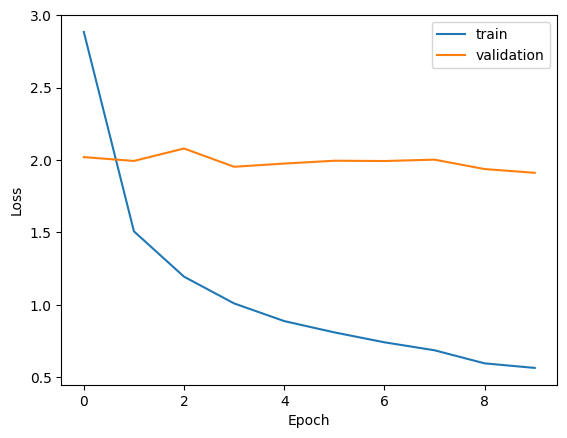

In [15]:
plt.plot((history.history['loss']), label='train')
plt.plot((history.history['val_loss']), label='validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig('resnet_plantdoc_learning_curves.png')
plt.show()
